#  Vortex beam metasurface

In this notebook we are going to simulate the plasmonic interface fabricated in the paper titled: "Yu, N., Genevet, P., Kats, M. A., Aieta, F., Tetienne, J.-P., Capasso, F., & Gaburro, Z. (n.d.). Light Propagation with Phase Discontinuities: Generalized Laws of Reflection and Refraction"
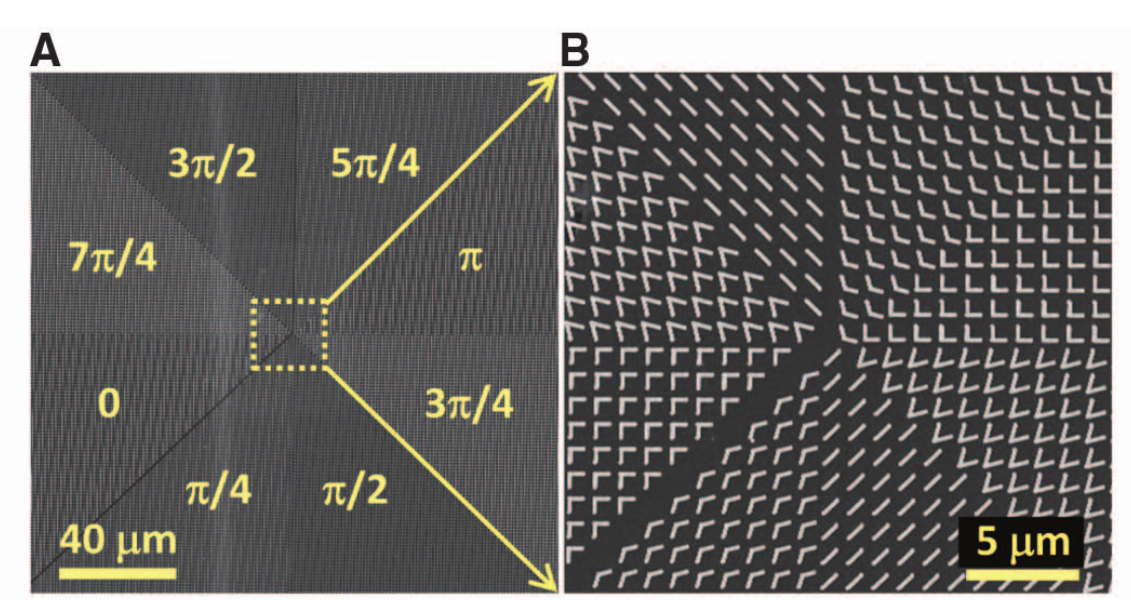

The metasurface is formed by 8 different unit cells distributed in each of the 8 octants of the metasurface, in order to create a phase discontinuity in steps of $\pi/4$. This will induce a spiral-like phase shift in an incident plane wave, yielding a vortex beam.

In [1]:
#importing libraries

import tidy3d as td
import numpy as np
from tidy3d import web
import matplotlib.pyplot as plt
from warnings import warn

The simulation will be parametrized by the number of unit cells in each direction (Nx and Ny variables),
the distance of the source from the structure and from the PML, and the lattice constant.

The model consists of a hemi-infinite substrat of silicon in the -z direction, the metasurface and an air region. An x-polarized plane wave is incident from the -z to z direction, and a field monitor is placed in order to store the fields profile in the frequency domain, and project them to the far-field.

In [2]:
#target wavelength
Wl = 8

#lattice constant
latticeConstant = 1.5

#parameters of the fabricated antennas
width = 0.22
thickness = 0.05

#distance of the source from structures and pml
distanceSourceStructure = 2
distanceSourcePml = 2

#defining the central frequency and linewidth of the source
fcen = td.C_0/Wl
fwidth = 0.2*fcen

#simulation run time
runTime = 1e-12

    
Nx = 15 #number of unit cells in each direction
Ny = 15 #these parameters were chosen in order to obtain an approximate uniform number of unit cells in each octant


#Ensuring an even number of unit cells helps achieve a more evenly distributed pattern around the center.
if Nx%2 != 0:
    Nx += 1
    warn('Odd numbers of unit cells not allowded. Add +1 to Nx variable')
if Ny%2 != 0:
    Ny += 1
    warn('Odd numbers of unit cells not allowded. Add +1 to Ny variable')
    
    
    
#the size of the plane of the metasurface as a function of the number of unit cells and lattice constant.
    #there is an 1.5 lattice constant added in each side, in order to avoid structures touching the PML.
sx = (Nx+3)*latticeConstant
sy = (Ny+3)*latticeConstant

#distance between monitor-source and monitor-PML
padMonitor = 2

#defining the z-size of the simulation
sz = distanceSourceStructure + distanceSourcePml +  2*padMonitor

#defining the thickness of the substrate region 
substrateThickness = distanceSourceStructure + distanceSourcePml

#defining the Z position of the metasurface
structureZPosition = -sz/2 + substrateThickness + thickness/2

#defining monitor Z position
monitorZPosition = structureZPosition  + padMonitor

#defining the center position and size of the source
centerSource = (0,0,sz/2 - substrateThickness -  distanceSourceStructure)
sizeSource = (td.inf,td.inf,0)

/tmp/ipykernel_83119/1704124523.py:30: UserWarning: Odd numbers of unit cells not allowded. Add +1 to Nx variable
  warn('Odd numbers of unit cells not allowded. Add +1 to Nx variable')
/tmp/ipykernel_83119/1704124523.py:33: UserWarning: Odd numbers of unit cells not allowded. Add +1 to Ny variable
  warn('Odd numbers of unit cells not allowded. Add +1 to Ny variable')


Here we will define an auxiliary function to return the antenna structure. The antenna is modeled as two block arms initialy in a "theta" angle (45 or -45 deg), that are tilted apart from each other by the angle "delta". The other free parameter is the length of the arms. In order to make the structures smoothier, and more similar to the SEM images, a cylinder is added in the junction of the arms.

In [3]:
def vAntennaBlock(center,length,
              delta,theta):

    """
    Create a V-antenna structure.

    Parameters:
        center (tuple): Center coordinates of the antenna.
        length (float): Length of the antenna arms.
        delta (float): Angle in between the antenna arms (radians).
        theta (float): Tilt angle of the antenna arms (radians).

    Returns:
        list: List of Tidy3D structures representing the V-antenna.
    """
    
    medium = td.material_library['Au']['Olmon2012crystal'] #using the built-in gold model that is modeled for the
    delta1 = (-theta+delta/2)*np.pi/180                     #frequency range of interest
    delta2 = (-theta-delta/2)*np.pi/180
    
    #junction between arms
    cylinder1 = td.Structure(geometry = td.Cylinder(radius = width/2,
                        center = center,
                        axis = 2,
                         length = thickness),
                           medium = medium)
    
    #distance to dislocate in order to position each arm
    dx = (length/2)*np.cos(delta1)
    dy = (length/2)*np.sin(delta1)

    #defining a first arm in the original position, that is then rotated, moved to the desired position,
     #and moved again in order to define the center as the junction between the two arms
    c1 = td.Box(size = (length,width, thickness),
                     center = (0,0,0)).rotated(delta1,2).translated(*center).translated(dx,dy,0)
    s1 = td.Structure(geometry = c1,
                      medium = medium)

    
    #second arm
    dx = (length/2)*np.cos(delta2)
    dy = (length/2)*np.sin(delta2)
    
    
    c2 = td.Box(center = (0,0,0),
                     size = (length,width, thickness)).rotated(delta2,2).translated(*center).translated(dx,dy,0)
    s2 = td.Structure(geometry = c2,
                      medium = medium)

    return [s1,s2,cylinder1]

#dictionary object that stores the parameters of each unit cell
dicNumerator = {0:(90,45,1.1),
                 1:(90+45,45,0.9),
                 2:(180,45,0.8),
                 3:(45,-45,1.3),
                 4:(-90,-45,1.1),
                 5:(-90-45,-45,0.9),
                 6:(180,-45,0.8),
                 7:(45,45,1.3)}

    

Since the structures are much smaller than the target wavelength, it is convenient to build a mesh override region around the metasurface to proper resolve the structures, and use a coarse mesh in the free space propagation

In [4]:
meshOverride = td.MeshOverrideStructure(geometry = td.Box(
                                            center = (0,0,structureZPosition),
                                        size = (sx,sy,
                                                thickness)),
                                        dl = (0.02,)*3)

In [5]:
#Defining the plane wave source, with a gaussian time profile
sourceTime = td.GaussianPulse(freq0 = fcen,
                              fwidth = fwidth)

sourcePw = td.PlaneWave(center = centerSource,
                      size = sizeSource,
                      direction = '+',
                      pol_angle = 0,
                      source_time = sourceTime)

In [6]:
#Defining the substrate region
substrate = td.Structure(geometry = td.Box.from_bounds(rmin = (-2*sx,-2*sy,-2*substrateThickness),
                                                       rmax = (2*sx,2*sy,-sz/2 + substrateThickness)),
                                           medium = td.Medium(permittivity = 3.47**2))

# Building the metasurface

In order to proper position the unit cells and build the model of the metasurface, we defined the function classifyOctant, that takes the x and y position of one unit cell and returns the octant where the structure belongs. Since angles such as 45 and 315 deg may be ambiguous, as they are in the exact threshold of two octants, there is an if condition for the 315 angle in order to promote a more even distribution.

In [7]:
def classifyOctant(x,y):

    angle =180 +  180*(np.arctan2(y,x)/np.pi)
    octant = angle//45.00
    octant = octant if angle != 315 else octant - 1
    return octant,angle


In [8]:
#list object to store the antennas
structures = []

#loops iterating in both dimensions
for x in range(Nx):
    for y in range(Ny):


        #defining the position of the unit cell
        posX = ( (Nx/2)  - x)*latticeConstant - latticeConstant*0.5
        posY = ( (Ny/2) - y)*latticeConstant - latticeConstant*0.5

        
        #defining angle and octant
        octant,angle = classifyOctant(posX,posY)

        #another if condition to remove the 45 degree row in the lower half of the metasurface, for it is more similar 
            #to what was done in the experiment
        if (abs(angle - 45) >= 0.1) and (((posX == 0) and posY > 0) ==False):
            if (posX == -posY) and (posY < 0):
                octant -= 1
                      
            #antenna parameters for a given octant
            _delta,_theta,_length = dicNumerator[octant]
            
            #adding the antenna to the list
            structures += (vAntennaBlock(center = (posX,posY,structureZPosition),
                 length = _length,
                 delta = _delta,
                 theta = _theta))



In [9]:
#defing the far-field monitor that will store the near field and project it to the far field

farFieldMonitor = td.FieldProjectionCartesianMonitor(center = (0,0,monitorZPosition),
                                                     size  = (td.inf,td.inf,0),
                                                     normal_dir = '+',
                                                     freqs = [fcen],
                                                     x = 300*np.linspace(-0.5,0.5,100),
                                                     y = 300*np.linspace(-0.5,0.5,100),
                                                     proj_axis = 2,
                                                     proj_distance = 20*Wl,
                                                      far_field_approx = False,
                                                      name = 'ff')        

20:48:18 -03 WARNING: Structure at structures[1] was detected as being less than
             half of a central wavelength from a PML on side x-max. To avoid    
             inaccurate results or divergence, please increase gap between any  
             structures and PML or fully extend structure through the pml.      

             WARNING: Suppressed 982 WARNING messages.                          

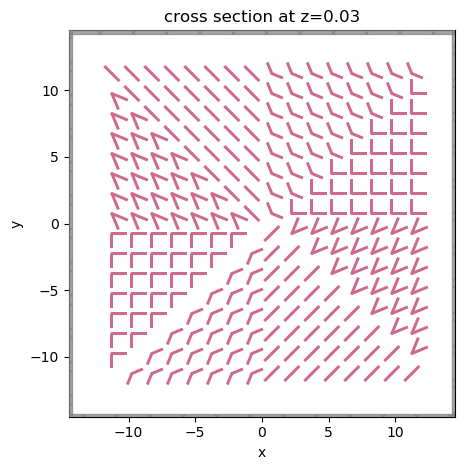

In [10]:
#defining the simulation
sim = td.Simulation(size = (sx,sy,sz),
                    grid_spec = td.GridSpec.auto(min_steps_per_wvl=20, #grid specification and mesh override
                                                 override_structures = [meshOverride]),
                        structures = [substrate] + structures,
                    sources = [sourcePw],
                    monitors = [farFieldMonitor],
                    run_time = runTime,
                    boundary_spec=td.BoundarySpec( #all bounderies are pmls in order to simulate a finite structure
                    x=td.Boundary.pml(),
                    y=td.Boundary.pml(),
                    z=td.Boundary.pml()))

#plot of the x,y plane in order to vizualize the metasurface
sim.plot(z=structureZPosition)

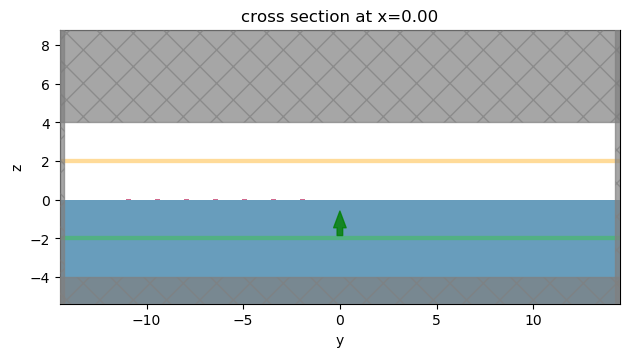

In [11]:
#plot in the x = 0 plane, in order to double check source, structures and monitor position
sim.plot(x=0)

In [12]:
#3d plot 
sim.plot_3d()

In [13]:
#estimating the credit cost of the simulation
task_id = web.upload(sim, task_name = "Metasurface")
print(web.estimate_cost(task_id))

20:48:22 -03 Created task 'Metasurface' with task_id                            
             'fdve-9e4e6c0a-db50-4c56-b7a9-dca1aecd2b9e' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=400143;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9e4e6c0a-db50-4c56-b7a9-dca1aecd2b9e\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=941286;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9e4e6c0a-db50-4c56-b7a9-dca1aecd2b9e\taskId]8;;\]8;id=400143;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9e4e6c0a-db50-4c56-b7a9-dca1aecd2b9e\=]8;;\]8;id=798799;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9e4e6c0a-db50-4c56-b7a9-dca1aecd2b9e\fdve]8;;\]8;id=400143;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9e4e6c0a-db50-4c56-b7a9-dca1aecd2b9e\-9e4e6c0a-db5]8;;\
             ]8;id=400143;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9e4e6c0a-db50-4c56-b7a9-dca1aecd2b9e\0-4c56-b7a9-dca1aecd2b9e']8;;\.

Output()

20:48:26 -03 Maximum FlexCredit cost: 1.673. Minimum cost depends on task       
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

1.6727947532727665


In [14]:
#running the simulation
results = web.run(sim, "Metasurface", folder_name = "data", path="data/%s.hdf5"%'1', verbose="True")

             Created task 'Metasurface' with task_id                            
             'fdve-196f466c-304a-4f36-a879-73a3fc1e2501' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=178760;https://tidy3d.simulation.cloud/workbench?taskId=fdve-196f466c-304a-4f36-a879-73a3fc1e2501\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=873876;https://tidy3d.simulation.cloud/workbench?taskId=fdve-196f466c-304a-4f36-a879-73a3fc1e2501\taskId]8;;\]8;id=178760;https://tidy3d.simulation.cloud/workbench?taskId=fdve-196f466c-304a-4f36-a879-73a3fc1e2501\=]8;;\]8;id=403824;https://tidy3d.simulation.cloud/workbench?taskId=fdve-196f466c-304a-4f36-a879-73a3fc1e2501\fdve]8;;\]8;id=178760;https://tidy3d.simulation.cloud/workbench?taskId=fdve-196f466c-304a-4f36-a879-73a3fc1e2501\-196f466c-304]8;;\
             ]8;id=178760;https://tidy3d.simulation.cloud/workbench?taskId=fdve-196f466c-304a-4f36-a879-73a3fc1e2501\a-4f36-a879-73a3fc1e2501']8;;\.

Output()

20:48:31 -03 status = queued

Output()

20:48:35 -03 status = preprocess

20:48:41 -03 Maximum FlexCredit cost: 1.673. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

             running solver

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

20:49:56 -03 early shutoff detected at 56%, exiting.

20:49:57 -03 status = postprocess

Output()

20:49:59 -03 status = success

             View simulation result at                                          
             ]8;id=135297;https://tidy3d.simulation.cloud/workbench?taskId=fdve-196f466c-304a-4f36-a879-73a3fc1e2501\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=588101;https://tidy3d.simulation.cloud/workbench?taskId=fdve-196f466c-304a-4f36-a879-73a3fc1e2501\taskId]8;;\]8;id=135297;https://tidy3d.simulation.cloud/workbench?taskId=fdve-196f466c-304a-4f36-a879-73a3fc1e2501\=]8;;\]8;id=77599;https://tidy3d.simulation.cloud/workbench?taskId=fdve-196f466c-304a-4f36-a879-73a3fc1e2501\fdve]8;;\]8;id=135297;https://tidy3d.simulation.cloud/workbench?taskId=fdve-196f466c-304a-4f36-a879-73a3fc1e2501\-196f466c-304]8;;\
             ]8;id=135297;https://tidy3d.simulation.cloud/workbench?taskId=fdve-196f466c-304a-4f36-a879-73a3fc1e2501\a-4f36-a879-73a3fc1e2501']8;;\.

Output()

20:50:03 -03 loading simulation from data/1.hdf5

             WARNING: Structure at structures[1] was detected as being less than
             half of a central wavelength from a PML on side x-max. To avoid    
             inaccurate results or divergence, please increase gap between any  
             structures and PML or fully extend structure through the pml.      

             WARNING: Suppressed 982 WARNING messages.                          

/tmp/ipykernel_83119/18228916.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  ff['Ey'].real.plot(cmap = 'inferno').figure.show()


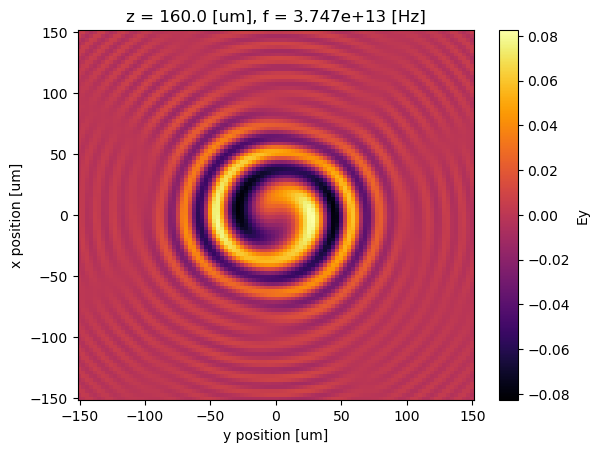

In [15]:
#retrieving the projected far field from the monitor
ff = results['ff'].fields_cartesian

#plotting only the cross polarized component (Ey). In the experiments, a polarizer was used to cut off the 
    #scattered light with the same polarization as the incident wave
    
#visualizing the electric field
ff['Ey'].real.plot(cmap = 'inferno').figure.show()


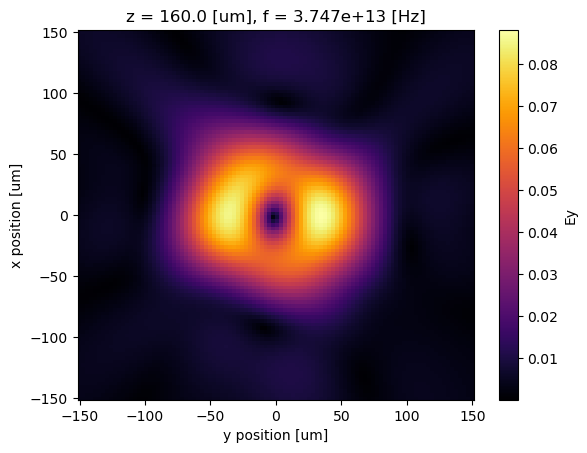

In [16]:
#visualizing the far-field profile
abs(ff['Ey']).plot(cmap = 'inferno')

Comparing with the experimental one:

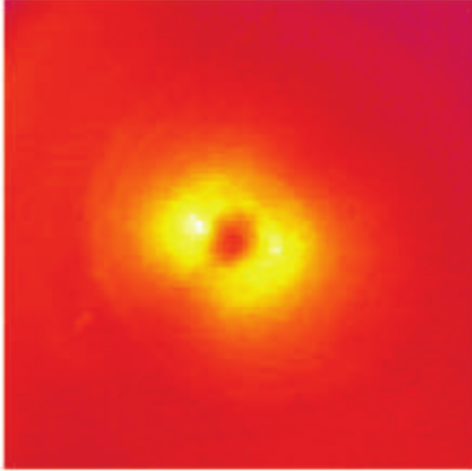

It is possible to observe, both in the simulation and in the experiment, the formation of a phase singularity at the center of the beam, leading to a region of zero field.

It is possible to obtain the phase profile by interfering the beam with a colinear gaussian beam. In order to reproduce that, we can use the analytical expression for the gaussian beam and create the interference with the simulated beam.

(-0.5, 99.5, 99.5, -0.5)

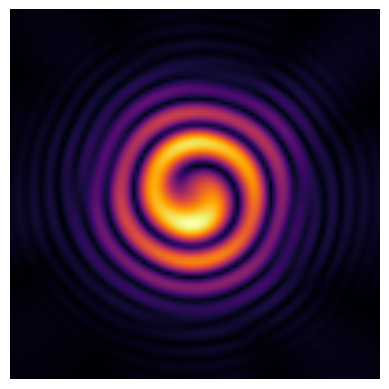

In [17]:
#gaussiam beam function
def E(r,z,lda = 1, E0 = 1, w0 = 1,
      n = 1):
    k = 2*np.pi/lda
    zr = np.pi*w0**2*n/lda
    wz = w0*np.sqrt(1 + (z/zr)**2)
    Rz = z*(1+(zr/z)**2)
    phi = np.arctan(z/zr)
    
    return E0*(w0/wz)*np.exp(-(r**2)/(wz**2))*np.exp(-1j*(k*z  +k*r**2/(2*Rz) - phi))

#creating the data points
x = np.linspace(-40,40,100)
y = x.copy()

X,Y = np.meshgrid(x,y)
r = np.sqrt(X**2 + Y**2)

#creating the gaussiam beam field 
gb  =E(r,1,8,w0 = 20)

#plotting the interference pattern
fig,ax = plt.subplots()
ax.imshow(abs(ff['Ey'].squeeze().T/ff['Ey'].max() + gb),
         interpolation = 'bilinear',
         cmap = 'inferno')
ax.axis('off')

# Comparing with the experimental result

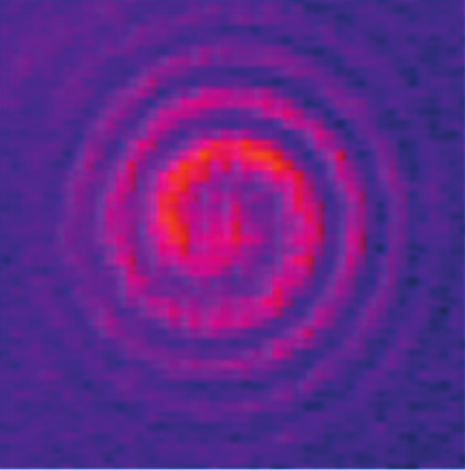